# Classification based on RF model

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


db = pd.read_csv('train.csv')
db['CabinDeck'] = db['Cabin'].str.extract(r'([A-Za-z]+)')
db['CabinNum'] = db['Cabin'].str.extract(r'(\d+)')
db['CabinSide'] = db['Cabin'].str.extract(r'([A-Za-z]+)$')

num_col = db.select_dtypes(include = ['int', 'float'])
cat_col = db.select_dtypes(include = ['object'])
cat_col.drop(['Name', 'Cabin', 'PassengerId', 'CabinNum'], axis=1, inplace=True)



,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,...,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S
0,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Preprocessing (MINMAXSCALER and One-Hot Encoder)

In [ ]:
# Define the numerical and categorical column names
numerical_cols = num_col.columns
categorical_cols = cat_col.columns

# Define the preprocessing steps for numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the preprocessing for both numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit and transform the data
processed_data = preprocessor.fit_transform(db)

cat_encoded_feature_names = preprocessor.named_transformers_['cat']\
    .named_steps['onehot'].get_feature_names_out(categorical_cols)

# # Concatenate the numerical and categorical column names
column_names = np.concatenate((numerical_cols, cat_encoded_feature_names))

# # Convert the processed data array to a DataFrame
processed_df = pd.DataFrame(processed_data, columns=column_names)
processed_df.insert(0, 'PassengerId', db['PassengerId'])
processed_df.insert(1, 'CabinNum', db['CabinNum'])
processed_df.insert(2, 'Transported', db['Transported'])
processed_df['CabinNum'].fillna(processed_df['CabinNum'].mode()[0], inplace=True)
processed_df.head()

## Correlation Analysis

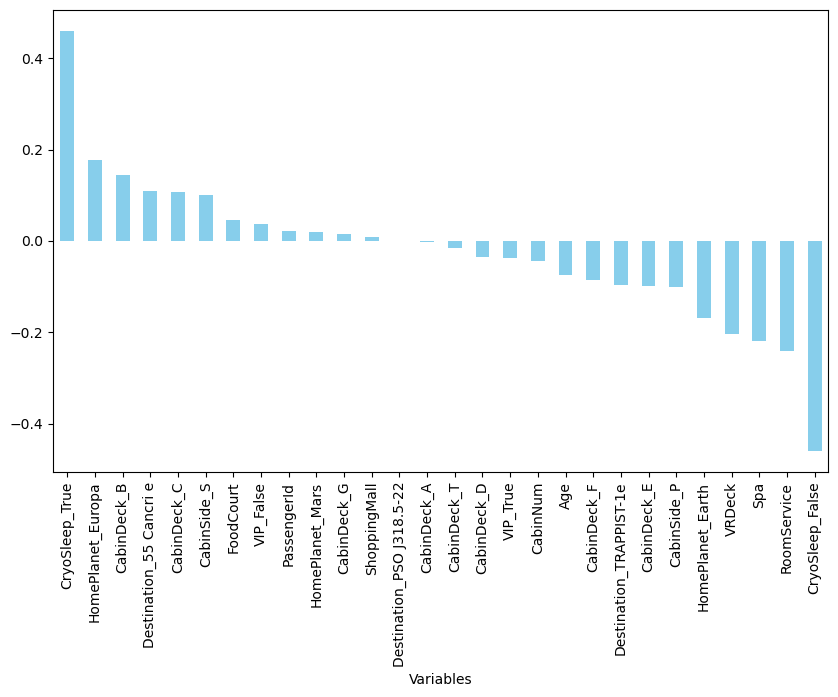

In [5]:
correlation = processed_df.corr()['Transported'].sort_values(ascending=False)
correlation.drop(['Transported'], inplace = True)
plt.figure(figsize=(10, 6))
correlation.plot(kind= 'bar', color = 'skyblue', xlabel = 'Variables')
plt.show()

In [6]:
correlation = processed_df.corr()['Transported'].sort_values(ascending=False)
correlation

Transported                  1.000000
CryoSleep_True               0.460132
HomePlanet_Europa            0.176916
CabinDeck_B                  0.144733
Destination_55 Cancri e      0.108722
CabinDeck_C                  0.108193
CabinSide_S                  0.101397
FoodCourt                    0.045583
VIP_False                    0.037261
PassengerId                  0.021491
HomePlanet_Mars              0.019544
CabinDeck_G                  0.016269
ShoppingMall                 0.009391
Destination_PSO J318.5-22    0.000092
CabinDeck_A                 -0.002623
CabinDeck_T                 -0.014568
CabinDeck_D                 -0.034046
VIP_True                    -0.037261
CabinNum                    -0.044012
Age                         -0.074233
CabinDeck_F                 -0.086360
Destination_TRAPPIST-1e     -0.096319
CabinDeck_E                 -0.097965
CabinSide_P                 -0.101397
HomePlanet_Earth            -0.168845
VRDeck                      -0.204874
Spa         

## Training model based don RF algrothm

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data = processed_df

X = data.drop(['Transported'], axis=1)
y = data['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create SVC model object
RF_model = RandomForestClassifier()

# Fit the model on the training data
RF_model.fit(X_train, y_train)

# Predict on the test data
y_pred = RF_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.7958596894767107
